In [84]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set()
import warnings
warnings.filterwarnings('ignore')




from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import SVR

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# Regression metrics
from sklearn.metrics import explained_variance_score, mean_squared_error
from sklearn.metrics import mean_absolute_error, r2_score

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [85]:


class bikeSales:
    
    
    file = 'clean_sport2.csv'
    df = None
    scaled_df = None
    model = {'Model': None,
             'Features': [],
             'Score': 0}
    
    
    
    
    def read_data(self):
        df = pd.read_csv(self.file,
                         parse_dates=['First_Seen','Last_Seen','Last_Modified'], 
                         infer_datetime_format=True)
        self.df = df
        return


    def add_dummy_variables(self, categorical_features=None):
        
        if (categorical_features == None):
            categorical_features = self.df.select_dtypes(exclude='number').columns
            
        additional = pd.get_dummies(self.df[categorical_features])
        self.df[additional.columns] = additional
        
        self.df.drop(categorical_features, axis=1, inplace=True)
        return

    def feature_plot(model,X,top=10):

        feats_imp = pd.DataFrame(model.feature_importances_, index=X.columns, columns=['FeatureImportance'])
        feats_imp = feats_imp.sort_values('FeatureImportance', ascending=False)[:top]

        feats_imp.plot(kind='barh', figsize=(12,6), legend=False)
        plt.title('Feature Importance from XgBoost Classifier')
        sns.despine(left=True, bottom=True)
        plt.gca().invert_yaxis()
        return

    def plot_accuracy_predictions(self, y_test, pred):
        fig, ax = plt.subplots(figsize=(12,10))
        ax.scatter(y_test,pred)
        ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=0.8)
        ax.set_xlabel('Measured')
        ax.set_ylabel('Predicted')
        ax.set_title('Accuracy of Predictions')
        return
    
    
    def scale_data(self, target='Price'):
        local_df = self.df.select_dtypes(include='number')

        features = list(set(local_df.columns) - set([target]))

        sc = StandardScaler()
        sc.fit(self.df[features])
        s = sc.transform(self.df[features])
        self.scaled_df = pd.DataFrame(s,columns=features)

        return
    
    
    def adjusted_r2(self, r2, n, k):
        return 1 - (1-r2)*((n-1)/(n-k-1)) 


    def find_best_model(self, features, y, scaled=False):
        
        self.model['Features'] = features
        X = self.df[features]
        y = self.df['Price']
        
        if scaled == True:
            X = self.scaled_df[features]
            

        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.3)

        best_score = 0
        models = []

        models.append(("LassoCV",LassoCV(cv=5)))
        models.append(("LinearRegression",LinearRegression()))
        models.append(("PassiveAggressiveRegressor",PassiveAggressiveRegressor()))
        models.append(("RidgeCV",RidgeCV(cv=5)))
        models.append(("Bagging",BaggingRegressor()))
        models.append(("SVR",SVR()))

        n, k = X_train.shape

        for name, model in models:
            score = cross_val_score(model, X_train, y_train,  cv=5)

            result = self.adjusted_r2(score,n,k)
                    
            if (result.mean() > best_score):
                best_score = result.mean()
                self.model['Model'] = model
                self.model['Score'] = result.mean()
                
        return

    def feature_selection(self, features):
        ## Use Forward Feature Selection to pick a good model
        
        target = 'Price'
        #features = list(set(self.df.columns) - set([target]))
        X = self.df[features]
        y = self.df[target]

        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.3)

        # start with no predictors
        included = []
        # keep track of model and parameters
        best = {'feature': '', 'r2': 0, 'a_r2': 0}
        # create a model object to hold the modelling parameters
        model = self.model['Model'] 
        # get the number of cases in the test data
        n = X_test.shape[0]

        while True:
            changed = False

            # list the features to be evaluated
            excluded = list(set(features) - set(included))

            # for each remaining feature to be evaluated
            for new_column in excluded:

                # fit the model with the Training data
                fit = model.fit(X_train[included + [new_column]], y_train) # fit a model; consider which predictors should be included
                # calculate the score (R^2 for Regression)
                r2 = model.score(X_test[included + [new_column]], y_test) # calculate the score
                # number of predictors in this model
                k = len(included + [new_column]) + 1
                # calculate the adjusted R^2
                adjusted_r = self.adjusted_r2(r2,n,k) 


                # if model improves
                if adjusted_r > best['a_r2']:
                    # record new parameters
                    best = {'feature': new_column, 'r2': r2, 'a_r2': adjusted_r}
                    # flag that found a better model
                    changed = True

            # if found a better model after testing all remaining features
            if changed:
                # update control details
                included.append(best['feature'])
                excluded = list(set(excluded) - set(best['feature']))
#                 print('Added feature %-4s with R^2 = %.3f and adjusted R^2 = %.3f' % 
#                       (best['feature'], best['r2'], best['a_r2']))
            else:
                # terminate if no better model
                break

        print('')
        print('Resulting features:')
        print(', '.join(included))
        self.model['Features'] = included
        
        return
        
        

    def fit(self, X, y):
        self.model['Model'].fit(X, y)
        return
        
        
    def predict(self, X):
        return self.model['Model'].predict(X)
    
    def deal_type(self):
#         if ('Predicted_Price' not in list(self.df.columns)):
#             raise 
        
        self.df['Price_ratio'] = self.df['Price'] / self.df['Predicted_Price']

        self.df['Deal_type'] = 'Dont Bother'
        self.df['Deal_type'][self.df['Price_ratio'] < 0.9] = 'Negotiate'
        self.df['Deal_type'][self.df['Price_ratio'] < 0.8] = 'Good Deal'
        self.df['Deal_type'][self.df['Price_ratio'] < 0.75] = 'Great Deal'        
        self.df['Deal_type'][self.df['Price_ratio'] < 0.5] = 'Its a steal'
        
#         self.df['Deal_type'][self.df['Price_ratio'] > 1.1] = 'Negotiate'
#         self.df['Deal_type'][self.df['Price_ratio'] > 1.2] = 'Good Deal'
#         self.df['Deal_type'][self.df['Price_ratio'] > 1.5] = 'Great Deal'        
#         self.df['Deal_type'][self.df['Price_ratio'] > 2.0] = 'Its a steal'
        
        return
        
    
    def plot_deals(self,x,y,hue=None,title='',figsize=(12,10)):
        ax = plt.figure(figsize=figsize)
        sns.scatterplot(x=x,y=y,hue=hue,data=self.df);
        plt.title(title,fontsize=14)
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        #plt.ylim(0,40000)




In [86]:
sport = bikeSales()


In [87]:
sport.read_data()

In [88]:
sport.df.shape

(2555, 69)

In [89]:
sport.add_dummy_variables()

In [90]:
sport.df.shape

(2555, 654)

In [91]:
features = list(set(sport.df.columns) - set(['Price']))
features

['Bike_Ninja 400 MY19 Road Manual 6sp',
 'Bike_Ninja ZX-14R ABS Special Edition  Road Manual 6sp 1400cc',
 'Bike_F4 312 R 1000 1+1',
 'Width',
 'Model_848',
 'Bike_CBR600F4i Road Manual 6sp 600cc',
 'Bike_CBR300R MY15 Road Manual',
 'Bike_Ninja ZX-14R ABS Special Edition  Road Manual 1400cc  ZX1400FEFA)',
 'Colour_white',
 'Bike_YZF-R6 MY16 Road Manual 6sp',
 'Brand_Bmw',
 'Engine_Config_L-Twin',
 'Model_Cbr600rr telefonica',
 'Model_Ninja zx 6r zx600r',
 'Registration_Expiry_01/07/2018',
 'Bike_F4 312 R 1000',
 'Model_Hayabusa gsx1300r',
 'Bike_DB8 Road Manual 6sp 1198cc',
 'Bike_S 1000 RR Sport',
 'Bike_CBR250R ABS Road Manual 6sp 250cc',
 'Country_of_Origin_INDONESIA',
 'Exhaust_Config_4 into 1',
 'Brand_Suzuki',
 'Bike_CBR600RR MY12 Road Manual 6sp',
 'Colour_silver',
 'Bike_GT650R EFI MY13 Road Manual 6sp',
 'Bike_Ninja ZX-10R ABS 30th Anniversary  Road Manual 6sp 1000cc',
 'Trail',
 'Registration_Expiry_01/03/2018',
 'Bike_Ninja ZX-10R ABS MY16 Road Manual 6sp',
 'Bike_MY14 Dayto

In [92]:
sport.find_best_model(features, sport.df['Price'])
sport.model

{'Model': BaggingRegressor(base_estimator=None, bootstrap=True,
          bootstrap_features=False, max_features=1.0, max_samples=1.0,
          n_estimators=10, n_jobs=None, oob_score=False, random_state=None,
          verbose=0, warm_start=False),
 'Features': ['Bike_Ninja 400 MY19 Road Manual 6sp',
  'Bike_Ninja ZX-14R ABS Special Edition  Road Manual 6sp 1400cc',
  'Bike_F4 312 R 1000 1+1',
  'Width',
  'Model_848',
  'Bike_CBR600F4i Road Manual 6sp 600cc',
  'Bike_CBR300R MY15 Road Manual',
  'Bike_Ninja ZX-14R ABS Special Edition  Road Manual 1400cc  ZX1400FEFA)',
  'Colour_white',
  'Bike_YZF-R6 MY16 Road Manual 6sp',
  'Brand_Bmw',
  'Engine_Config_L-Twin',
  'Model_Cbr600rr telefonica',
  'Model_Ninja zx 6r zx600r',
  'Registration_Expiry_01/07/2018',
  'Bike_F4 312 R 1000',
  'Model_Hayabusa gsx1300r',
  'Bike_DB8 Road Manual 6sp 1198cc',
  'Bike_S 1000 RR Sport',
  'Bike_CBR250R ABS Road Manual 6sp 250cc',
  'Country_of_Origin_INDONESIA',
  'Exhaust_Config_4 into 1',
  'Bra

In [71]:
sport.feature_selection(features)

print (len(sport.model['Features']))


Resulting features:
Maximum_Power, Age, Warranty_KMs_No, Time_to_Sale, Stroke, Model_Zx6r, Front_Suspension_Hydraulic, Bike_F4 RR Road Manual 1000cc
8


In [73]:
sport.fit(sport.df[sport.model['Features']],sport.df['Price'])

In [75]:
predictions = sport.predict(sport.df[sport.model['Features']])
sport.df['Predicted_Price'] = predictions

sport.df[['Price','Predicted_Price']].head()

,Price,Predicted_Price
0,600.0,2067.900000
1,1500.0,2098.666667
2,1700.0,2224.750000
3,1900.0,2156.126667
4,1990.0,2760.233333


In [76]:
sport.deal_type()

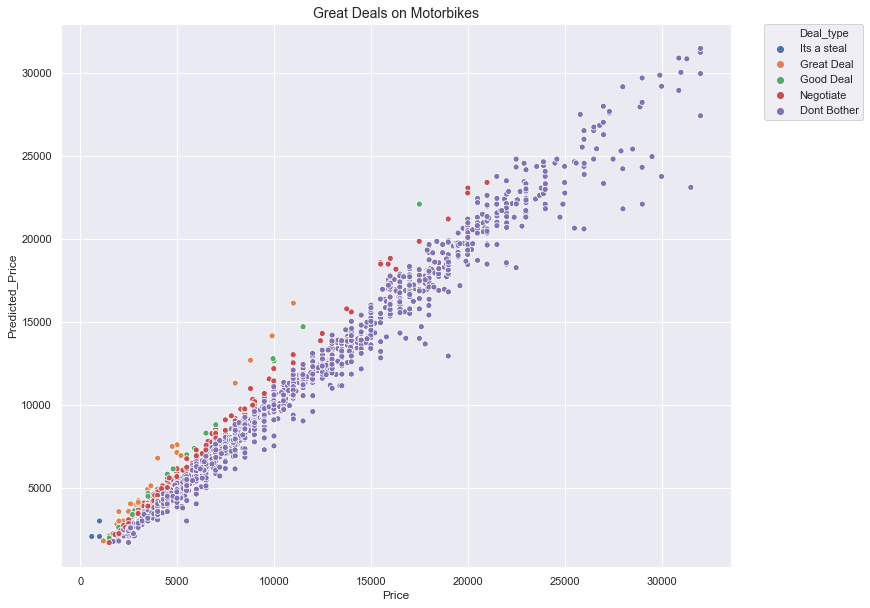

In [77]:
sport.plot_deals(x='Price',y='Predicted_Price',hue='Deal_type',title='Great Deals on Motorbikes')
    

In [28]:
# sport.scale_data(target='Price')
# sport.scaled_df.describe()

In [29]:
niave_feature = ['Kilometers','Age']
sport.find_best_model(niave_feature, sport.df['Price'])
print ('Model: ',sport.model['Model'])
print ('Score: ',sport.model['Score'])




Model:  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
Score:  0.12555495127724448


In [30]:
sport.fit(sport.df[niave_feature],sport.df['Price'])

predictions = sport.predict(sport.df[niave_feature])



In [31]:
sport.df['Predicted_Price'] = predictions
sport.df[['Price','Predicted_Price']].head()

,Price,Predicted_Price
0,600.0,665.588870
1,1500.0,5609.767570
2,1700.0,9263.921739
3,1900.0,4224.345332
4,1990.0,5741.545690


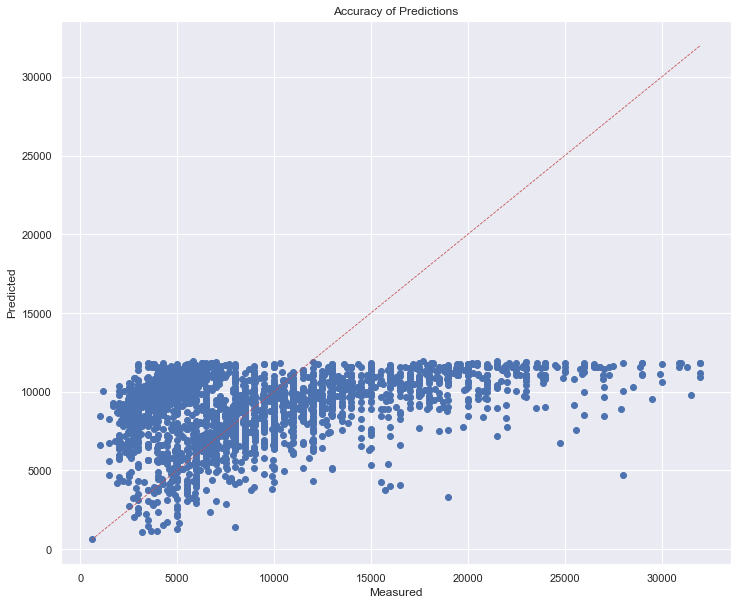

In [32]:
sport.plot_accuracy_predictions(sport.df['Price'],sport.df['Predicted_Price'])

In [33]:
sport.deal_type()

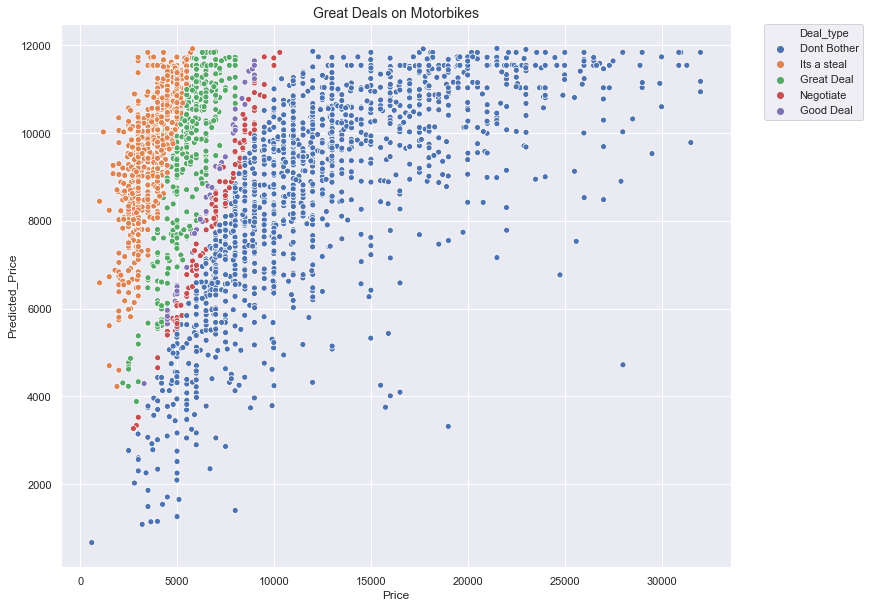

In [34]:
sport.plot_deals(x='Price',y='Predicted_Price',hue='Deal_type',title='Great Deals on Motorbikes')


In [93]:
bike_cols = [col for col in sport.df.columns if 'Bike' in col]
brand_cols = [col for col in sport.df.columns if 'Brand' in col]
model_cols = [col for col in sport.df.columns if 'Model' in col]
niave_feature = ['Kilometers','Age']


In [94]:
def run_pipeline(features=None):
    
    sport = bikeSales()
    sport.read_data()
    sport.add_dummy_variables()
    
    if (features == None):
        features = list(set(sport.df.columns) - set(['Price']))
    
    
    sport.find_best_model(features, sport.df['Price'])
    print ('Model: ',sport.model['Model'])
    print ('Score: ',sport.model['Score'])

    print ('Feature selection process.')
    sport.feature_selection(features)
    print ('Score: ',sport.model['Score'])
    
    # Optimise model parameters
    
    # Fit the full model
    sport.fit(sport.df[sport.model['Features']],sport.df['Price'])
    # Make predictions
    predictions = sport.predict(sport.df[sport.model['Features']])
    sport.df['Predicted_Price'] = predictions
    
    # Determine the deal type
    sport.deal_type()

    # Display the predicted deals
    sport.plot_deals(x='Price',y='Predicted_Price',hue='Deal_type',title='Great Deals on Motorbikes')
    
    return sport


Model:  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
Score:  0.12555495127724448
Feature selection process.

Resulting features:
Kilometers
Score:  0.12555495127724448


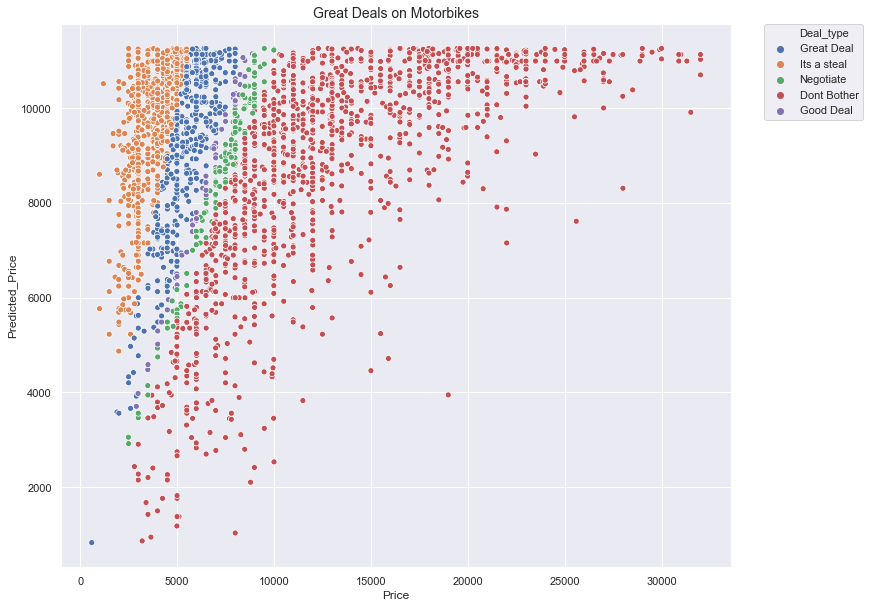

In [ ]:
run_pipeline(niave_feature)

In [ ]:
run_pipeline(bike_cols)

Model:  RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=5, fit_intercept=True,
    gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)
Score:  0.7204110102221719
Feature selection process.


In [ ]:
run_pipeline(brand_cols)

In [ ]:
run_pipeline(model_cols)

In [ ]:
obj = run_pipeline()

In [ ]:
obj.model

In [35]:
sport_df = sport.df
#sport_df.drop(['Predicted_Price','Price_ratio','Deal_type'],axis=1, inplace=True)

target = 'Price'
features = list(set(sport_df.select_dtypes(include='number').columns) - set([target]))

model = RidgeCV(cv=5)

X = sport_df[features]
y = sport_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.3)

n = X_train.shape[0]

best_score = 0
best_feature = ''
feature_set = features
included = []

# top 10 features
for i in range(10):

    print ('Iteration: ',i)
    for col in feature_set:

        model.fit(X_train[included + [col]], y_train)
        r2 = model.score(X_test[included + [col]], y_test)

        k = len(included + [col]) + 1
        score = adjusted_r2(r2,n,k) 

        if (score > best_score):
            best_score = score
            best_feature = col
            #print ('Found better feature: ',col, score)


    print ('Added ',best_feature)
    included.append(best_feature)
    print (f'Features: {best_feature}; score: {best_score:.3f}')
    # reset for the next round
    best_score = 0
    best_feature = ''
    feature_set = set(features) - set(included)

print (included)

Iteration:  0
Added  Maximum_Power
Features: Maximum_Power; score: 0.547
Iteration:  1
Added  Kilometers
Features: Kilometers; score: 0.682
Iteration:  2
Added  Traction_Control_Standard
Features: Traction_Control_Standard; score: 0.749
Iteration:  3
Added  Bore
Features: Bore; score: 0.778
Iteration:  4
Added  Time_to_Sale
Features: Time_to_Sale; score: 0.792
Iteration:  5
Added  Age
Features: Age; score: 0.803
Iteration:  6
Added  Cylinders
Features: Cylinders; score: 0.811
Iteration:  7
Added  Model_Yzf r1m
Features: Model_Yzf r1m; score: 0.817
Iteration:  8
Added  Cam_Type_DOHC (Double Over Head Cam)
Features: Cam_Type_DOHC (Double Over Head Cam); score: 0.824
Iteration:  9
Added  Model_Ninja zx 10r krt abs replica
Features: Model_Ninja zx 10r krt abs replica; score: 0.829
Iteration:  10
Added  Colour_none
Features: Colour_none; score: 0.835
Iteration:  11
Added  Ignition_Digital
Features: Ignition_Digital; score: 0.840
Iteration:  12
Added  Side_Stand_Start_Inhibitor_Standard
Feat

In [96]:

included

['Maximum_Power',
 'Kilometers',
 'Traction_Control_Standard',
 'Bore',
 'Time_to_Sale',
 'Age',
 'Cylinders',
 'Model_Yzf r1m',
 'Cam_Type_DOHC (Double Over Head Cam)',
 'Model_Ninja zx 10r krt abs replica',
 'Colour_none',
 'Ignition_Digital',
 'Side_Stand_Start_Inhibitor_Standard',
 'Bike_1199 Panigale R ABS Road Manual 1198cc',
 'Dry_Weight',
 'Linked_Braking_System_Part-Integral',
 'Bike_F3 800 RC Road Manual 6sp 800cc',
 'Model_1098s tri colore',
 'Model_1198 s corse edition',
 'Learner_Approved_No',
 'Ignition_CDI (Capacitive Discharge Ignition)',
 'Bike_GT650R EFI Road Manual 6sp 650cc',
 'Bike_Ninja ZX-10R ABS MY17 Road Manual 6sp',
 'Model_1198 s',
 'Model_899 panigale',
 'Carburettor_Constant velocity',
 'Model_Gsx r1000r',
 'Model_Ninja 300 se krt replica ex300a',
 'Bike_Ninja ZX-10RR  Road Manual 6sp 1000cc',
 'Rear_Suspension_Spring',
 'Rear_Brake_Caliper(s)_Four Piston',
 'Bike_YZF-R1M MY19 Road Manual 6sp',
 'Model_Panigale v4',
 'Side_Stand_Standard',
 'Bike_F4 1000 Ro

In [37]:
model = RidgeCV(cv=5)
model.fit(X_train[included], y_train)
model.score(X_test[included], y_test)

0.9070676541117689

In [43]:
model.fit(sport_df[included],sport_df[target])
predictions = model.predict(sport_df[included])
sport_df['Predicted_Price'] = predictions

In [44]:
sport_df['Price_ratio'] = sport_df['Price'] / sport_df['Predicted_Price']

sport_df['Deal_type'] = 'Dont Bother'
sport_df['Deal_type'][sport_df['Price_ratio'] > 1.1] = 'Negotiate'
sport_df['Deal_type'][sport_df['Price_ratio'] > 1.2] = 'Good Deal'
sport_df['Deal_type'][sport_df['Price_ratio'] > 1.5] = 'Great Deal'
sport_df['Deal_type'][sport_df['Price_ratio'] > 2] = 'Its a steel'



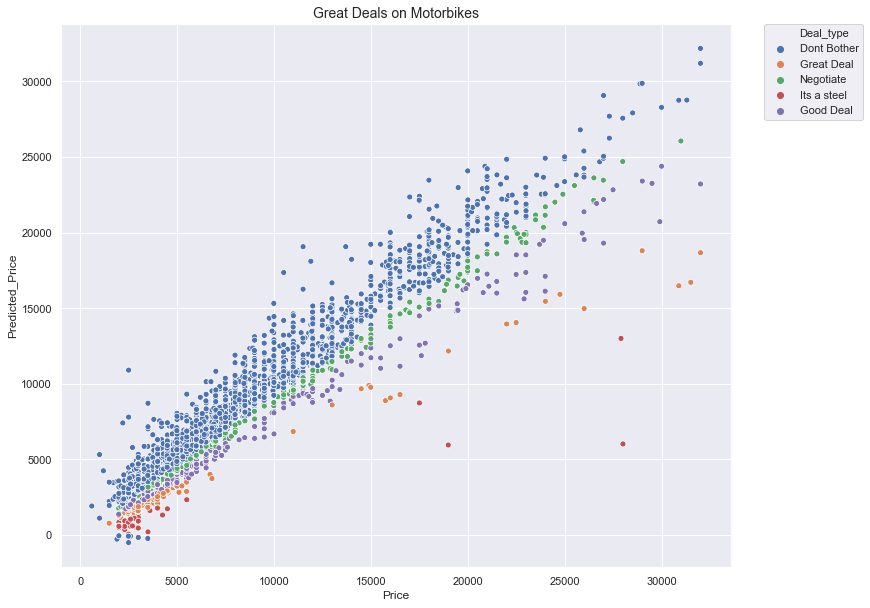

In [47]:
def scatter(data,x,y,hue=None,title='',figsize=(12,10)):
    ax = plt.figure(figsize=figsize)
    sns.scatterplot(x=x,y=y,hue=hue,data=data);
    plt.title(title,fontsize=14)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    #plt.ylim(0,40000)

scatter(sport_df,'Price','Predicted_Price',hue='Deal_type',title='Great Deals on Motorbikes')


In [27]:
sport.df.columns

Index(['Bore', 'Carburettor(s)', 'Compression_Ratio', 'Cylinders',
       'Dry_Weight', 'Engine_Description', 'Front_Brake_Diameter',
       'Front_Suspension_Travel', 'Fuel_Reserve_Capacity',
       'Fuel_Tank_Capacity',
       ...
       'Model_f4 1000 abs', 'Model_f4 1000s corse', 'Model_f4 312 r 1000',
       'Model_f4 312 r 1000 11', 'Model_f4 750 s', 'Model_f4 750 s f4s 11',
       'Model_f4 r', 'Model_f4 rr', 'Model_f4 rr 1000', 'Model_f4ago 1000'],
      dtype='object', length=1647)

In [216]:
bike_cols = [col for col in sport.df.columns if 'Bike' in col]
brand_cols = [col for col in sport.df.columns if 'Brand' in col]
model_cols = [col for col in sport.df.columns if 'Model' in col]
niave_feature = ['Kilometers','Age']


features = [niave_feature, bike_cols, brand_cols, model_cols]

for i, col in enumerate(features):
    
    sport.model = sport.find_best_model(col, sport.df['Price'])
    
    sport.fit(sport.df[niave_feature],sport.df['Price'])
    
    predictions = sport.predict(sport.df[niave_feature])
    sport.df['Predicted_Price_'+str(i)] = predictions

    
    
    

In [217]:
pred_cols = [col for col in sport.df.columns if 'Predicted' in col]
sport.df[pred_cols].head()

,Predicted_Price,Predicted_Price_0,Predicted_Price_1,Predicted_Price_2,Predicted_Price_3
0,5766.422408,5766.422408,5766.422408,5317.638077,5766.422408
1,9793.277150,9793.277150,9793.277150,9997.887675,9793.277150
2,4239.099500,4239.099500,4239.099500,3502.268535,4239.099500
3,5903.430252,5903.430252,5903.430252,4923.078853,5903.430252
4,7352.072148,7352.072148,7352.072148,6921.687257,7352.072148


In [97]:
sport_df[['Price','Predicted_Price','Price_ratio','Deal_type']][sport_df['Price'] > 15000].head(10)

,Price,Predicted_Price,Price_ratio,Deal_type
1127,15200.0,15942.485560,0.953427,Dont Bother
1128,15200.0,14838.217986,1.024382,Dont Bother
1129,15500.0,16299.801669,0.950932,Dont Bother
1130,15500.0,15537.357269,0.997596,Dont Bother
1131,15500.0,15509.065737,0.999415,Dont Bother
1132,15500.0,15844.266557,0.978272,Dont Bother
1133,15500.0,11012.781500,1.407456,Good Deal
1134,15500.0,11697.645542,1.325053,Good Deal
1135,15600.0,17851.471749,0.873878,Dont Bother
1136,15700.0,16723.216950,0.938815,Dont Bother
